In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.integrate import odeint, ode, solve_ivp
import seaborn as sns
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy import interpolate
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")
%run -i '../../../../../utils.py'

# Read data

In [46]:
# read metadata
df_meta = pd.read_csv('../../../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']

# read SCFA
df_scfa = pd.read_csv('../../../../../our_data/SCFA.csv', index_col=0)

df_meta_scfa = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_meta_scfa.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,Acetate,Propionate,Butyrate,Total
SampleID,,,,,,,,,
sample141,BI1,Beijing,0,Inulin,A,5.233899,1.930933,1.109582,8.702693
sample142,BI2,Beijing,0,Inulin,B,13.459823,3.621771,1.546647,19.235932
sample143,BI3,Beijing,0,Inulin,D,18.075378,2.859916,1.682656,23.217751
sample144,BI4,Beijing,0,Inulin,E,12.580368,3.148773,1.477688,17.614381
sample145,BI5,Beijing,0,Inulin,C,8.065127,3.134209,1.835172,13.577951


# Read predicted harmonic model parameters

In [47]:
df_par_intra = pd.read_csv('intrapolation/predicted_model_params__elasticnet__intrapolation.csv')
df_par_intra.head()

,Unnamed: 0,SCFA,Group2Exclude,Train/Test,MiceID,Parameter,PredictedValue
0,0,Acetate,A,train,HI5,k1,0.079392
1,1,Acetate,A,train,SI2,k1,0.155611
2,2,Acetate,A,train,GI2,k1,0.001596
3,3,Acetate,A,train,HI4,k1,0.092141
4,4,Acetate,A,train,BI3,k1,0.084118


In [48]:
df_par_extra = pd.read_csv('extrapolation/predicted_model_params__elasticnet__extrapolation.csv')
df_par_extra.head()

,Unnamed: 0,SCFA,Vendor2Exclude,Train/Test,MiceID,Parameter,PredictedValue
0,0,Acetate,Beijing,train,SI2,k1,0.388415
1,1,Acetate,Beijing,train,SI4,k1,0.068823
2,2,Acetate,Beijing,train,HI5,k1,0.234874
3,3,Acetate,Beijing,train,HI2,k1,0.353448
4,4,Acetate,Beijing,train,GI2,k1,0.003333


# Predict SCFA concentration using harmonic parameters

In [49]:
def overdampling(params,xdata):
    k1,k2,D,H,Ai = params
    ypred = H/k1/k2+((D+k2*Ai-H/k1)*np.exp(-k1*xdata)-(D+k1*Ai-H/k2)*np.exp(-k2*xdata))/(k2-k1)
    return ypred

In [50]:
lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    for perturbationtype in ['intrapolation','extrapolation']:
        for predictiontype in ['train','test']:
            if perturbationtype=='intrapolation':
                df_tmp = df_par_intra[(df_par_intra.SCFA==scfa)&(df_par_intra['Train/Test']==predictiontype)]
                symbol2exclude = 'Group2Exclude'
            if perturbationtype=='extrapolation':
                df_tmp = df_par_extra[(df_par_extra.SCFA==scfa)&(df_par_extra['Train/Test']==predictiontype)]
                symbol2exclude = 'Vendor2Exclude'
            
            all_symbols = list(set(df_tmp[symbol2exclude]))
            for symbol in all_symbols:
                all_mice = list(set(df_tmp[df_tmp[symbol2exclude]==symbol].MiceID))
                for mice in all_mice:
                    k1 = list(df_tmp.loc[(df_tmp[symbol2exclude]==symbol)&(df_tmp.MiceID==mice)&(df_tmp.Parameter=='k1'),'PredictedValue'])[0]
                    k2 = list(df_tmp.loc[(df_tmp[symbol2exclude]==symbol)&(df_tmp.MiceID==mice)&(df_tmp.Parameter=='k2'),'PredictedValue'])[0]
                    D = list(df_tmp.loc[(df_tmp[symbol2exclude]==symbol)&(df_tmp.MiceID==mice)&(df_tmp.Parameter=='D'),'PredictedValue'])[0]
                    H = list(df_tmp.loc[(df_tmp[symbol2exclude]==symbol)&(df_tmp.MiceID==mice)&(df_tmp.Parameter=='H'),'PredictedValue'])[0]
                    Ai = list(df_meta_scfa.loc[(df_meta_scfa.MiceID==mice)&(df_meta_scfa.Day==0),scfa])[0]

                    xdata = np.array(list(df_meta_scfa.loc[(df_meta_scfa.MiceID==mice)&(df_meta_scfa.Day>0),'Day']))
                    ydata_obs = list(df_meta_scfa.loc[(df_meta_scfa.MiceID==mice)&(df_meta_scfa.Day>0),scfa])
                    ydata_pred = overdampling([k1,k2,D,H,Ai], xdata)
                    
                    if min(ydata_pred)<0:
                        assert 0
                    
                    r2 =  r2_score(ydata_obs, ydata_pred)

                    for x,y1,y2 in zip(xdata, ydata_obs, ydata_pred):
                        lines.append([scfa, perturbationtype, predictiontype, mice, x, y1, y2, r2])
        
df_pred = pd.DataFrame(lines, columns=['SCFA','PerturbationType','PredictionType','MiceID','Day','ObservedValue','PredictedValue','R2'])
df_pred.head()

,SCFA,PerturbationType,PredictionType,MiceID,Day,ObservedValue,PredictedValue,R2
0,Acetate,intrapolation,train,GI3,1,17.811334,13.706695,-0.226152
1,Acetate,intrapolation,train,GI3,3,28.755036,18.660382,-0.226152
2,Acetate,intrapolation,train,GI3,5,36.586820,20.455452,-0.226152
3,Acetate,intrapolation,train,GI3,8,13.650937,21.209059,-0.226152
4,Acetate,intrapolation,train,GI3,13,14.790116,21.282946,-0.226152


# Scatter plot of observed vs. computed SCFA concentrations

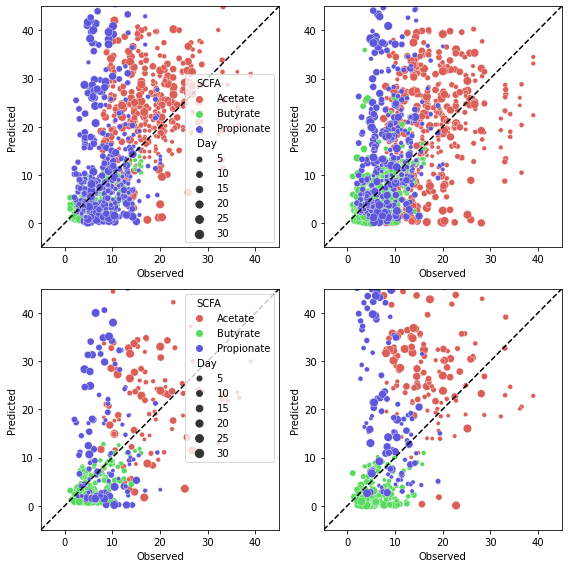

In [52]:
fig, ax = plt.subplots(figsize=(8,8), nrows=2, ncols=2)

# training, intrapolation
_ = sns.scatterplot(x='ObservedValue',y='PredictedValue', hue='SCFA', size='Day', palette=sns.color_palette("hls", 3), 
                    data=df_pred[(df_pred.PredictionType=='train')&(df_pred.PerturbationType=='intrapolation')], ax=ax[0,0])
_ = ax[0,0].plot([-5,45],[-5,45],'k--')
_ = ax[0,0].set_xlim([-5,45])
_ = ax[0,0].set_ylim([-5,45])
_ = ax[0,0].set_xlabel('Observed')
_ = ax[0,0].set_ylabel('Predicted')

# training, extrapolation
_ = sns.scatterplot(x='ObservedValue',y='PredictedValue', hue='SCFA', size='Day', palette=sns.color_palette("hls", 3), 
                    data=df_pred[(df_pred.PredictionType=='train')&(df_pred.PerturbationType=='extrapolation')], ax=ax[0,1])
_ = ax[0,1].plot([-5,45],[-5,45],'k--')
_ = ax[0,1].set_xlim([-5,45])
_ = ax[0,1].set_ylim([-5,45])
_ = ax[0,1].set_xlabel('Observed')
_ = ax[0,1].set_ylabel('Predicted')
_ = ax[0,1].legend().remove()

# testing, intrapolation
_ = sns.scatterplot(x='ObservedValue',y='PredictedValue', hue='SCFA', size='Day', palette=sns.color_palette("hls", 3), 
                    data=df_pred[(df_pred.PredictionType=='test')&(df_pred.PerturbationType=='intrapolation')], ax=ax[1,0])
_ = ax[1,0].plot([-5,45],[-5,45],'k--')
_ = ax[1,0].set_xlim([-5,45])
_ = ax[1,0].set_ylim([-5,45])
_ = ax[1,0].set_xlabel('Observed')
_ = ax[1,0].set_ylabel('Predicted')

# testing, extrapolation
_ = sns.scatterplot(x='ObservedValue',y='PredictedValue', hue='SCFA', size='Day', palette=sns.color_palette("hls", 3), 
                    data=df_pred[(df_pred.PredictionType=='test')&(df_pred.PerturbationType=='extrapolation')], ax=ax[1,1])
_ = ax[1,1].plot([-5,45],[-5,45],'k--')
_ = ax[1,1].set_xlim([-5,45])
_ = ax[1,1].set_ylim([-5,45])
_ = ax[1,1].set_xlabel('Observed')
_ = ax[1,1].set_ylabel('Predicted')
_ = ax[1,1].legend().remove()
 
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scatter_plot_training_prediction.svg", format="svg")

# Plot R2 (combine for all test tests)

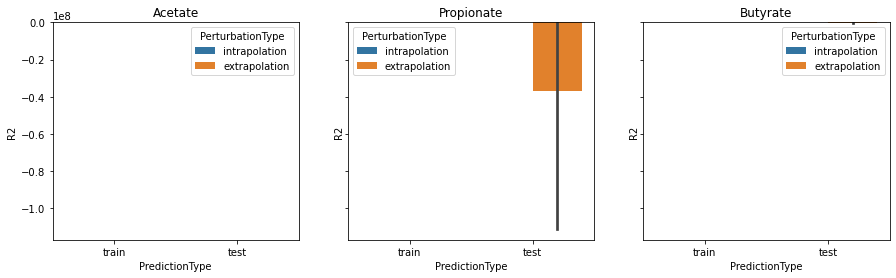

In [54]:
df_R2 = df_pred.drop(['Day','ObservedValue','PredictedValue'],axis=1).drop_duplicates()

fig,ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3, sharey=True)
for k,scfa_ in enumerate(['Acetate','Propionate','Butyrate']):
    _=sns.barplot(x='PredictionType', y='R2', hue='PerturbationType', data=df_R2[df_R2.SCFA==scfa_], ax=ax[k])
    ax[k].set_title(scfa_)